In [7]:
import cv2
from numpy import ndarray, dtype, generic

def prepare_input_image(image_path: str) -> ndarray[int, dtype[generic]]:
    img = cv2.imread(image_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [8]:
import numpy as np


def noisy(noise_typ, image):
    if noise_typ == "gauss":
        row, col, ch = image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row, col, ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row, col, ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1.0 - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ == "speckle":
        row, col = image.shape
        gauss = np.random.randn(row, col)
        gauss = gauss.reshape(row, col)
        noisy = image + image * gauss
        return noisy


In [3]:
# Prepare input images

import cv2
import timeit
from lab3_face_recognition_method_comparison.definitions import HAAR_CASCADES_DIR, FACE_DB_DIR, DATA_OUTPUT_DIR
from pathlib import Path

def prepare_input(image_path: Path, scale_factor: float = 1.3, min_neighbours: int = 3):
    img = cv2.imread(str(image_path))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(str(HAAR_CASCADES_DIR / 'haarcascade_frontalface_default.xml'))
    # image, scaleFactor(1.00 ..), minNeighbors (1, 2, ..), minSize, maxSize
    faces = face_cascade.detectMultiScale(img, scale_factor, min_neighbours)
    paths = []
    img = img.copy()
    for i, (x,y,w,h) in enumerate(faces):
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        f = cv2.resize(gray[y:y+h, x:x+w], (200, 200))
        paths.append(f"{FACE_DB_DIR}/{image_path.name.rstrip('.jpg')}/vardas_{i}.pgm")
        if not (FACE_DB_DIR / image_path.name.rstrip('.jpg')).exists():
            (FACE_DB_DIR / image_path.name.rstrip('.jpg')).mkdir(parents=True)
        cv2.imwrite(f'{FACE_DB_DIR}/{image_path.name.rstrip(".jpg")}/vardas_{i}.pgm', f)

    
    print("Detected faces: %d" %len(faces))
    cv2.imwrite(f"{DATA_OUTPUT_DIR}/{image_path.name}", img)
    return paths

In [4]:
from lab3_face_recognition_method_comparison.definitions import DATA_INPUT_DIR, DATA_OUTPUT_DIR

input_image_1 = prepare_input(DATA_INPUT_DIR / "input_1.jpg")
input_image_2 = prepare_input(DATA_INPUT_DIR / "input_2.jpg")

Detected faces: 4
Detected faces: 4


In [11]:
img = cv2.imread(str((DATA_INPUT_DIR / "input_1.jpg")))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = noisy("speckle", gray)
cv2.imwrite(f"{DATA_OUTPUT_DIR}/noisy.png", gray)


True

In [12]:
img = cv2.imread("/home/fox/Projects/General/learning-portfolio/university/masters/digital-image-processing/lab3_face_recognition_method_comparison/data/facedb/input_1/vardas_0.pgm")
cv2.imwrite(f"{DATA_OUTPUT_DIR}/1.png", img)
img = cv2.imread("/home/fox/Projects/General/learning-portfolio/university/masters/digital-image-processing/lab3_face_recognition_method_comparison/data/facedb/input_1/vardas_1.pgm")
cv2.imwrite(f"{DATA_OUTPUT_DIR}/2.png", img)
img = cv2.imread("/home/fox/Projects/General/learning-portfolio/university/masters/digital-image-processing/lab3_face_recognition_method_comparison/data/facedb/input_1/vardas_2.pgm")
cv2.imwrite(f"{DATA_OUTPUT_DIR}/3.png", img)
img = cv2.imread("/home/fox/Projects/General/learning-portfolio/university/masters/digital-image-processing/lab3_face_recognition_method_comparison/data/facedb/input_1/vardas_3.pgm")
cv2.imwrite(f"{DATA_OUTPUT_DIR}/4.png", img)

True

In [22]:
import pandas as pd

df = pd.read_csv("/home/fox/Projects/General/learning-portfolio/university/masters/digital-image-processing/lab3_face_recognition_method_comparison/data/output/eigen/experiment_9_0.csv")
(df['label'] == df['true_label']).mean()

0.25

In [29]:
import cv2
import numpy as np
import re
import traceback
import pandas as pd
from enum import Enum
from bayes_opt.event import DEFAULT_EVENTS, Events


class Counter:
    """
    Count the number of calls made to the wrapped function.
    """

    def __init__(self, func):
        self.counter = 0
        self.func = func

    def __call__(self, *args, **kwds):
        self.counter += 1
        return self.func(*args, **kwds)

    def reset(self):
        self.counter = 0


# read images
def read_images(dir: Path):
    for face in dir.iterdir():
        if face.is_file():
            img = cv2.imread(str(face))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            yield (gray, re.findall(r"\d+", face.name)[0])


# prepare training dataset
[xl, yl] = [[], []]
for x, y in list(read_images(FACE_DB_DIR / "input_1")):
    xl.append(x)
    yl.append(y)

yl = np.asarray(yl, dtype=np.int32)

# for saving results


class Method(Enum):
    EIGEN = "eigen"
    FISHER = "fisher"
    LBPH = "lbph"


@Counter
def perform_experiment(model, data_dir: Path, **kwargs: int):
    model.train(np.asarray(xl), np.asarray(yl))
    img = cv2.imread(str((DATA_INPUT_DIR / "input_1.jpg")))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = noisy("speckle", gray)
    face_cascade = cv2.CascadeClassifier(
        str(HAAR_CASCADES_DIR / "haarcascade_frontalface_default.xml")
    )
    faces = face_cascade.detectMultiScale(img, 1.3, 3)
    rows = []
    for i, (x, y, w, h) in enumerate(faces):
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        f = cv2.resize(gray[y : y + h, x : x + w], (200, 200))
        try:
            params = model.predict(f)
            rows.append(
                {
                    "label": params[0],
                    "true_label": i,
                    "confidence": params[1],
                }
                | kwargs
            )
            cv2.putText(
                img, f"T: {i}", (x, y + 100), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2
            )
            cv2.putText(
                img,
                f"D: {params[0]}",
                (x, y + 150),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                255,
                2,
            )
        except Exception:
            traceback.print_exc()
    cv2.imwrite(
        f"{data_dir}/experiment_{'_'.join(str(val) for val in kwargs.values())}.png",
        img,
    )
    df = pd.DataFrame(rows)
    df.to_csv(
        f"{data_dir}/experiment_{'_'.join(str(val) for val in kwargs.values())}.csv",
        index=False,
    )
    return df[df["label"] == df["true_label"]]["confidence"].sum()


# model blackbox function
def which_model(model: Method):
    if model == Method.EIGEN:

        def eigen_bbox(num_components: float, threshold: float):
            num_components, threshold = int(num_components), int(threshold)
            model = cv2.face.EigenFaceRecognizer_create(
                num_components=num_components, threshold=threshold
            )

            return perform_experiment(
                model,
                DATA_OUTPUT_DIR / "eigen",
                num_components=num_components,
                threshold=threshold,
            )

        return eigen_bbox
    elif model == Method.FISHER:

        def fisher_bbox(num_components: float, threshold: float):
            num_components, threshold = int(num_components), int(threshold)
            model = cv2.face.FisherFaceRecognizer_create(
                num_components=num_components, threshold=threshold
            )
            return perform_experiment(
                model,
                DATA_OUTPUT_DIR / "fisher",
                num_components=num_components,
                threshold=threshold,
            )

        return fisher_bbox
    elif model == Method.LBPH:

        def lbph_bbox(radius: float, grid: float, threshold: float):
            radius, grid, threshold = int(radius), int(grid), int(threshold)
            model = cv2.face.LBPHFaceRecognizer_create(
                radius=radius, grid_x=grid, grid_y=grid, threshold=threshold
            )
            return perform_experiment(
                model,
                DATA_OUTPUT_DIR / "lbph",
                radius=radius,
                neighbors=8,
                grid=grid,
                threshold=threshold,
            )

        return lbph_bbox


from bayes_opt import BayesianOptimization

threshold_bounds = (0, 100000)
other_bounds = (1, 1000)

pbounds = {
    Method.EIGEN: {"num_components": other_bounds, "threshold": threshold_bounds},
    Method.FISHER: {"num_components": other_bounds, "threshold": threshold_bounds},
    Method.LBPH: {
        "radius": (1, 100),
        "grid": other_bounds,
        "threshold": threshold_bounds,
    },
}

for method, bounds in pbounds.items():
    if method == Method.FISHER:
        optimizer = BayesianOptimization(which_model(method), bounds)
        optimizer.maximize(init_points=5, n_iter=100)
        print(optimizer.res)
        rows = [{"confidence_sum": item['target']} | item["params"] for item in optimizer.res]
        df = pd.DataFrame(rows)
        df.astype(int).to_csv(f"{DATA_OUTPUT_DIR}/{method.value}.csv", index=False)

# method = Method.LBPH

# optimizer = BayesianOptimization(
#     f=which_model(method), pbounds=pbounds[method]
# )

# optimizer.maximize(
#     init_points=5,
#     n_iter=1,
# )

# rows = [{"confidence_sum": item['target']} | item["params"] for item in optimizer.res]
# df = pd.DataFrame(rows)
# df.astype(int).to_csv(f"{DATA_OUTPUT_DIR}/{method.value}.csv", index=False)
# df


|   iter    |  target   | num_co... | threshold |
-------------------------------------------------


NameError: name 'noisy' is not defined

In [14]:
from os import path
import pandas as pd

method = "lbph"
csvs = [file for file in (DATA_OUTPUT_DIR / method).iterdir() if file.suffix == ".csv"]
csvs.sort(key=lambda file: path.getmtime(file))
dfs = [pd.read_csv(csv) for csv in csvs]
df_final = [
    {
        "experiment": i,
        "correct": (df["label"] == df["true_label"]).sum(),
        "incorrect": ((df["label"] != df["true_label"]) & (df["label"] != -1)).sum(),
        "unrecognized": (df["label"] == -1).sum(),
        "total": 4,
        "avg_confidence": df["confidence"].mean(),
        "max_confidence": df["confidence"].max(),
        "min_confidence": df["confidence"].min(),
        "sum_confidence_correct": df[df["label"] == df["true_label"]][
            "confidence"
        ].sum(),
    }
    | {column: df[column][0] for column in df.columns[3:]}
    for i, df in enumerate(dfs)
]

df_final = pd.DataFrame(df_final)
(df_final['correct']/df_final['total']).mean()
# dfs[0]
# path.getmtime(DATA_OUTPUT_DIR / "lbph")


0.32142857142857145

Text(0.5, 0, 'threshold')

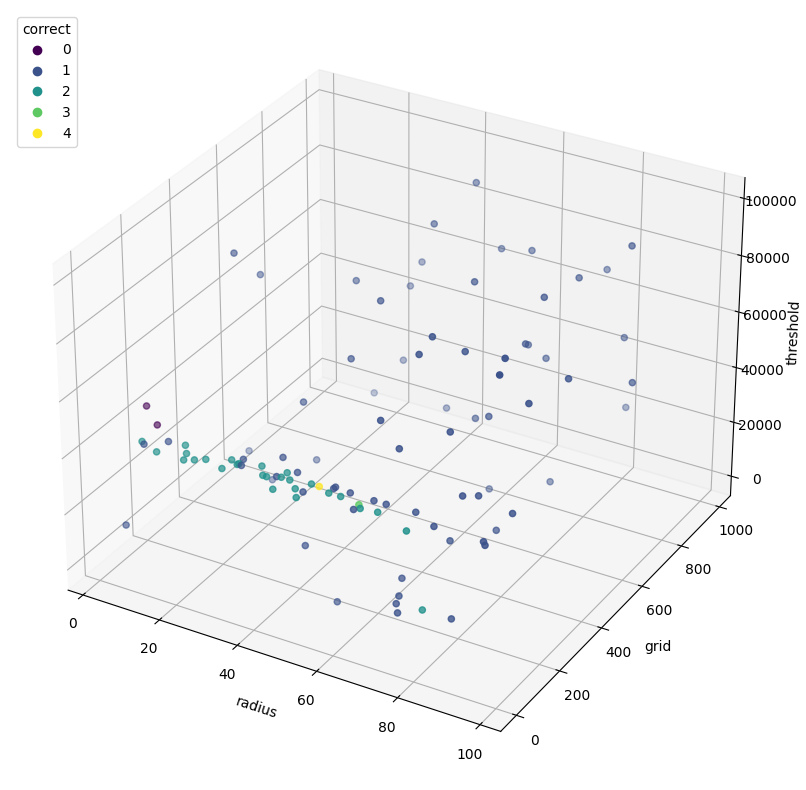

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(df_final['radius'], df_final['grid'], df_final['threshold'], c=df_final['correct'])
legend1 = ax.legend(*[scatter.legend_elements()[0],['0','1','2','3','4', 'f']], 
                    title="correct", loc='upper left')
ax.set_xlabel('radius')
ax.set_ylabel('grid')
ax.set_zlabel('threshold')

In [13]:
# Face detector
import cv2
import numpy as np
import re
import traceback
import pandas as pd

def read_images(dir: Path):
        for face in dir.iterdir():
            if face.is_file():
                img = cv2.imread(str(face))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                yield (gray, re.findall(r"\d+", face.name)[0])

[xl, yl] = [[], []]
for x, y in list(read_images(FACE_DB_DIR / "input_1")):
    xl.append(x)
    yl.append(y)

yl = np.asarray(yl, dtype=np.int32)

rows = []
for z in range(0, 100, 10):
    model = cv2.face.EigenFaceRecognizer_create(num_components = z)
    # model = cv2.face.FisherFaceRecognizer_create(num_components = 9, threshold = z)
    # model = cv2.face.LBPHFaceRecognizer_create(radius = 9, neighbors=8, grid_x = 100, grid_y = 100, threshold=z)
    model.train(np.asarray(xl), np.asarray(yl))
    img = cv2.imread(str((DATA_INPUT_DIR / "input_1.jpg")))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = noisy("speckle", gray)
    face_cascade = cv2.CascadeClassifier(str(HAAR_CASCADES_DIR / 'haarcascade_frontalface_default.xml'))
    faces = face_cascade.detectMultiScale(img, 1.3, 3)
    for i, (x,y,w,h) in enumerate(faces):
        print(f"Face {i}: {x}, {y}, {w}, {h}")
        print("===")
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        f = cv2.resize(gray[y:y+h, x:x+w], (200, 200))
        print(f.shape)
        try:
            params = model.predict(f)
            rows.append({"label": params[0], "true_label": i, "confidence": params[1], "z": z})
            cv2.putText(img, f"T: {i}", (x, y + 100),  cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
            cv2.putText(img, f"D: {params[0]}", (x, y + 150),  cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
        except Exception as e:
            traceback.print_exc()
    cv2.imwrite(f"{DATA_OUTPUT_DIR}/experiment_EigenFace_{z}.png", img)

df = pd.DataFrame(rows)
df.to_csv(f"{DATA_OUTPUT_DIR}/experiment_EigenFace_.csv")

Face 0: 438, 15, 63, 63
===
(200, 200)
Face 1: 347, 67, 55, 55
===
(200, 200)
Face 2: 224, 91, 53, 53
===
(200, 200)
Face 3: 126, 113, 62, 62
===
(200, 200)
Face 0: 438, 15, 63, 63
===
(200, 200)
Face 1: 347, 67, 55, 55
===
(200, 200)
Face 2: 224, 91, 53, 53
===
(200, 200)
Face 3: 126, 113, 62, 62
===
(200, 200)
Face 0: 438, 15, 63, 63
===
(200, 200)
Face 1: 347, 67, 55, 55
===
(200, 200)
Face 2: 224, 91, 53, 53
===
(200, 200)
Face 3: 126, 113, 62, 62
===
(200, 200)
Face 0: 438, 15, 63, 63
===
(200, 200)
Face 1: 224, 91, 53, 53
===
(200, 200)
Face 2: 347, 67, 55, 55
===
(200, 200)
Face 3: 126, 113, 62, 62
===
(200, 200)
Face 0: 438, 15, 63, 63
===
(200, 200)
Face 1: 347, 67, 55, 55
===
(200, 200)
Face 2: 224, 91, 53, 53
===
(200, 200)
Face 3: 126, 113, 62, 62
===
(200, 200)
Face 0: 438, 15, 63, 63
===
(200, 200)
Face 1: 347, 67, 55, 55
===
(200, 200)
Face 2: 126, 113, 62, 62
===
(200, 200)
Face 3: 224, 91, 53, 53
===
(200, 200)
Face 0: 438, 15, 63, 63
===
(200, 200)
Face 1: 347, 67, 55